# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- Elisabetta Pagliara,
    2- Liangwei, Chen
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

## Part 3:


Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [1]:
from PIL import Image
import glob
import os
import cv2
import skimage.io
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from skimage.filters import threshold_minimum
from skimage.filters import threshold_otsu
import numpy as np
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import random
import pandas as pd
import xml.etree.ElementTree as ET



In [2]:
# get the parent directory
data_base_path = os.path.join(os.pardir, 'data') 
#initialize this list to save all the train images
image_list = []

#uploas the 800 images of the train set
for filename in sorted(glob.glob(data_base_path+'/project-data/images/train/*.jpg')):# put sorted otheriwse the order is arbitrary!!
    im=cv2.imread(filename)
    image_list.append(im)

In [3]:
#uploas the 50 images of the test set
image_test_list=[]
for filename in sorted(glob.glob(data_base_path+'/project-data/images/test/*.jpg')[0:50]):# put sorted otheriwse the order is arbitrary!!
    im=cv2.imread(filename)
    image_test_list.append(im)


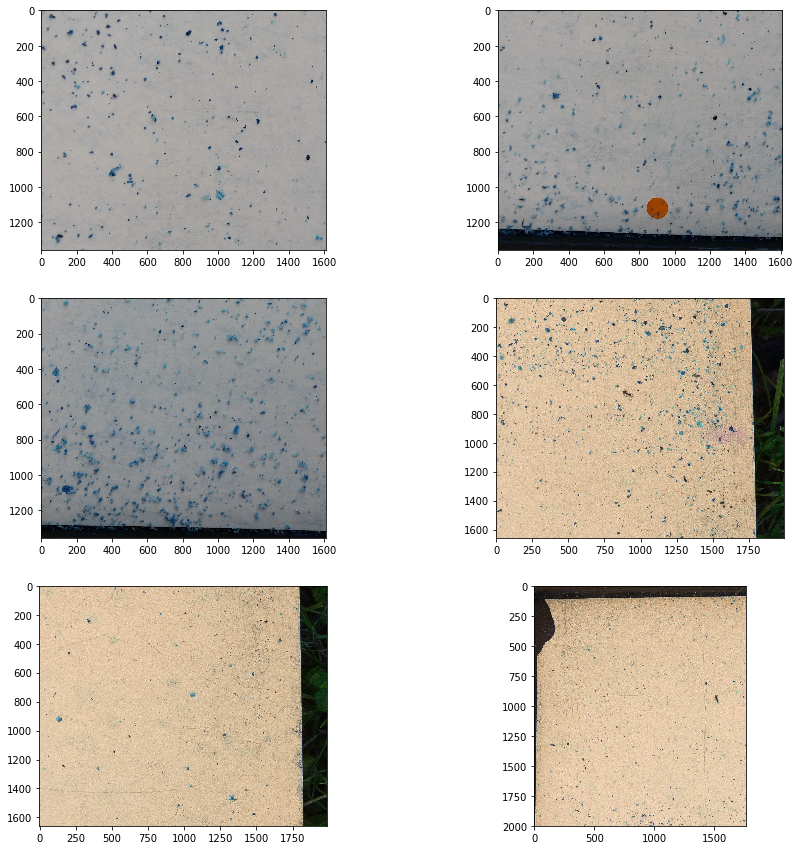

In [4]:
#look at some images in the train set:
nb_image=6
_,axes=plt.subplots(3,2,figsize=(15,15))
for i,ax,image in zip(range(nb_image),axes.ravel(),image_list[0:6]):
    
    ax.imshow(image)
plt.show()

In [5]:
#function for reading the ground thruth:

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [6]:
#extract the labels for the test and train set:
annotations_xmls=[parse_file(filename) for filename in sorted(glob.glob(data_base_path+'/project-data/annotations/train/*.xml'))]
annotations_test_xmls=[parse_file(filename) for filename in sorted(glob.glob(data_base_path+'/project-data/annotations/test/*.xml'))]

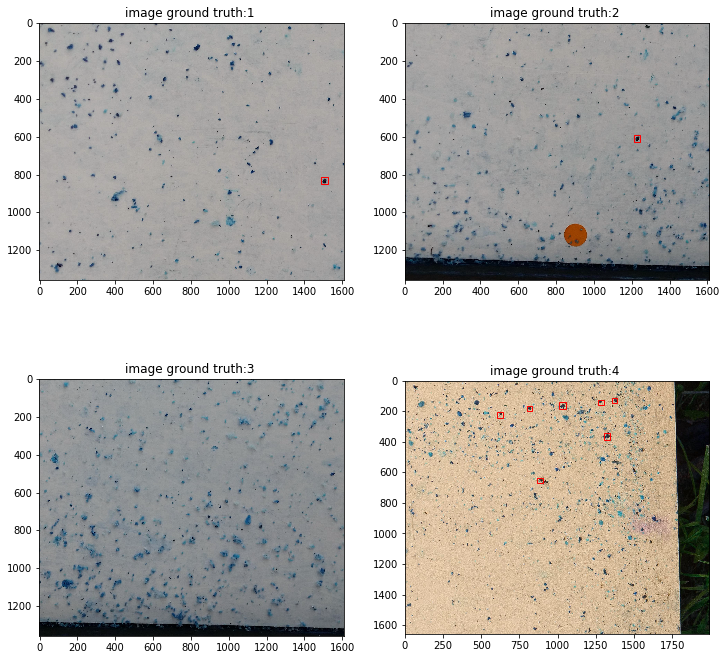

In [7]:
#look at the ground truth for 6 images in the training set
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
i=0
#just take the first 6 image and look where the varroa is...
annotations_red=annotations_xmls[0:4]
for ax,annotations in zip(axes.ravel() , annotations_red):
    
    # Iterate over annotations
    for anno in annotations:
        
        rect = mpatches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
   
    ax.imshow(image_list[i])
    i+=1
   
    ax.set_title('image ground truth:{} '.format(i))
plt.show()

In [10]:
# in this cell we are going to print the resulting average threshold and varroa's area with their 
#standard deviation. In the same time also the varroa's boxes area is calculated.

threshold=[]
area=[]
area_box=[]
ground_truth={}

for i,annotations in enumerate(annotations_xmls):
    true_values=[]
   
    for anno in annotations:
            
            #labels
            true_values.append([anno['bbox'][0],anno['bbox'][1],anno['bbox'][0]+anno['bbox'][2],anno['bbox'][1]+anno['bbox'][3]])
            #varroa's boxes area
            area_box.append([anno['bbox'][2]*anno['bbox'][3]])
            #threshold and area of the varroa
            thresh,area_=calculate_value_of_interest(image_list[i],anno['bbox'][0],anno['bbox'][1],anno['bbox'][2],anno['bbox'][3])
            
            threshold.append(thresh)
            area.append(area_)
    #dictionatu containing all the labels     
    ground_truth[str(i)]=[]
    ground_truth[str(i)].append(true_values)
        

resulting_threshold=np.mean(threshold,axis=0).round()  
area_final=np.mean(area).round()
print('the resulting threshold is  {} +/- {} '.format(resulting_threshold,np.std(threshold,axis=0).round()))
print('the resulting area is  {} +/- {} '.format(area_final,np.std(area).round()))


the resulting threshold is  [86. 86. 95.] +/- [30. 24. 23.] 
the resulting area is  329.0 +/- 166.0 


In [307]:
#this is how the label are saved for the training set images:
ground_truth

{'0': [[[1490, 815, 1524, 849]]],
 '1': [[[1210, 593, 1243, 626]]],
 '2': [[]],
 '3': [[[1267, 125, 1305, 159],
   [797, 164, 832, 200],
   [868, 634, 903, 668],
   [605, 207, 640, 245],
   [1356, 116, 1390, 149],
   [1010, 141, 1053, 185],
   [1303, 343, 1346, 387]]],
 '4': [[]],
 '5': [[[1410, 794, 1443, 833]]],
 '6': [[[939, 469, 967, 495],
   [1023, 644, 1059, 682],
   [1369, 526, 1404, 561],
   [1468, 892, 1501, 926],
   [1703, 1545, 1737, 1582],
   [1391, 948, 1431, 985],
   [1023, 1819, 1060, 1857],
   [451, 1249, 484, 1283],
   [1569, 1155, 1603, 1190],
   [1641, 1456, 1677, 1494],
   [1313, 759, 1351, 803],
   [879, 412, 915, 451],
   [1455, 907, 1490, 945]]],
 '7': [[]],
 '8': [[[858, 388, 892, 428],
   [440, 1339, 476, 1373],
   [42, 1484, 76, 1519],
   [151, 1045, 187, 1079],
   [1508, 1833, 1544, 1867],
   [244, 1793, 278, 1831],
   [905, 1598, 940, 1632],
   [716, 1929, 752, 1963],
   [1191, 1910, 1226, 1952],
   [630, 1240, 666, 1277],
   [709, 1844, 743, 1877],
   [756,

In [633]:
print('median area boxes: {}'.format(np.mean(area_box)))

median area boxes: 917.1033008151811


In [48]:
#let's gather the labels for the test_set:
ground_test_truth={}

for i,annotations in enumerate(annotations_test_xmls):
    true_values=[]
   
    for anno in annotations:
            
            #labels
            true_values.append([anno['bbox'][0],anno['bbox'][1],anno['bbox'][0]+anno['bbox'][2],anno['bbox'][1]+anno['bbox'][3]])
            
           
    #dictionatu containing all the labels     
    ground_test_truth[str(i)]=[]
    ground_test_truth[str(i)].append(true_values)
        

In [15]:
#function evaluating the intersection over union:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return round(iou,1)

In [16]:
#function evaluating if two images intersect :
def verify_intersection(real_value,prediction):
    if ((real_value[0]<prediction[2]) & (prediction[0]<real_value[2]) & (real_value[3]>prediction[1]) & (real_value[1]<prediction[3])):
        return True

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from keras.optimizers import SGD, Adam
import random
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In order to train our first neural network we need to have an equal portion of negative and positive classes.
We have decided to remove from the dictionary of the ground truth labels the images that not presented  any varroas. 



In [18]:
varroa_images=ground_truth.copy()
no_varroa_images=[]
for i in range(len(ground_truth)):
    if len(ground_truth[str(i)][0])==0:
        del varroa_images[str(i)]
        no_varroa_images.append(i)
   

From now on, we consider 'varroa_images' as the dictionary containing all the images with varroa and 'no_varroa_images' as a list containing all the number of images without any varroas. We realised that there are more images containing the varroa: 532 vs 268.
In order to take into account all the training images, we count how many crop varroas images were detected in the 532 positive sample and we randomly select the same number of images from the 268 negative samples.

Another key feature concerns the fact that all the training images were resized to [40*40] even though the mean value of the varroa's boxes area is 917 for the 800 training images. We agree ( and we test but the result is not shown here) that for decreasing the false negative a bigger boxes size should be considered.

In [19]:
print('images not containing the varroa : {}'.format(len(no_varroa_images)))
print('images containing the varroa : {}'.format(len(varroa_images)))

images not containing the varroa : 268
images containing the varroa : 532


In [20]:
print('median area boxes: {}'.format(np.average(area_box)))

median area boxes: 917.1033008151811


In [21]:
#function to resize the varroas boxes
def resize_image(image,new_height=40,
                 new_width=40,
                 method=cv2.INTER_LANCZOS4):
    
    
    dim=(new_width, new_height)        
    new_image = cv2.resize(image,dim,interpolation= method)  
    
    return new_image

In [22]:
#function to concatenate all the varroa's boxes obtained from the training images
def concatenate(image,labels,tot_labels,tot_images):
    
    for  values_im,values_lab in zip(image,labels):
        tot_images.append(values_im)
        tot_labels.append(values_lab)
    return (tot_images),tot_labels

In [23]:
#function that random selects window images from the training images that not present the varroas 
def extract_false_example(image,nb_false_ex,Random=False):
    
    if Random:
        portion_size=random.randint(33, 47)# in case we want to change the window size
    else:
        portion_size=40#select a window size of 40 *40
    image_size = (image.shape[0],image.shape[1])
    images=[]
    
    for i in range(nb_false_ex):#number of the false_example to sample for balance the false and positive classes
        

        x1 = random.randint(0, image_size[0]-portion_size-1)
        y1 = random.randint(0, image_size[1]-portion_size-1)
        
        x2, y2 = x1+portion_size, y1+portion_size

        images.append(image[x1:x2,y1:y2,:])

    return images



The first method of CNN trains over all the training images that represent the varroa's boxes.

In [24]:
#create the data and the label for the training : METHOD 1

tot_labels_train=[]
tot_images_train=[]
labels=[]
nb_images=len(varroa_images)


#training data from po samples
for i,values in enumerate((list(varroa_images.values())[0:nb_images])):
    
        flatten =  [item for sublist in values for item in (sublist) ]
        image_nb=int(list(varroa_images.keys())[i])
        image_varroa=[resize_image(image_list[image_nb][pixels[1]:pixels[3],pixels[0]:pixels[2],:])   for pixels in (flatten)]
        labels=[1 for j in range(len(image_varroa))]
    
        
        tot_images_train,tot_labels_train=concatenate(image_varroa,labels,tot_labels_train,(tot_images_train))

#numebr of sample to consider from each negative train classes
nb_of_sample=int(np.floor(len(tot_labels_train)/len(no_varroa_images)))

#training data from negative samples
for i in range(len(no_varroa_images)):
    image_varroa=extract_false_example(image_list[no_varroa_images[i]], nb_of_sample)
    labels=[0 for j in range(len(image_varroa))]
    
    tot_images_train,tot_labels_train=concatenate(image_varroa,labels,tot_labels_train,(tot_images_train))

In [25]:
#normalization of the training data
train_set=np.asarray(tot_images_train)/255
train_label=keras.utils.to_categorical(tot_labels_train) 

our neural networks contains 3 Cnn layers with kernel of 5 and 3 with selu activation function and 3 max pool layer with kernel and stride of 2.
The last two layers are 2 fully connected layers. A dropout has been added to avoid overfitting after each layer.
The last activation function is a sigmoid because we are dealing with a 2-class problem

In [26]:
cnnmodel = Sequential()
cnnmodel.add(Conv2D(32, kernel_size = (5,5), activation = 'relu',
            input_shape = (40,40,3)))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

cnnmodel.add(Conv2D(64, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

cnnmodel.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Dropout(0.25))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(200, activation='relu'))
cnnmodel.add(Dropout(0.2))
cnnmodel.add(Dense(2, activation='sigmoid'))

The optimizer is Adam and the loss function is the binary cross entropy , we decide a batch size of 300 and a validation set equal to the 0.3% of the total data. 15 epochs are considered to train the model.

In [27]:
adam = Adam()
cnnmodel.compile(loss = 'binary_crossentropy',
             optimizer = adam,
             metrics = ['accuracy'])
cnnhistory = cnnmodel.fit(train_set, train_label,
         epochs = 15,
         batch_size = 500,
         validation_split = .3,shuffle=True)

Train on 10303 samples, validate on 4416 samples
Epoch 1/15
10303/10303 [==============================] - 67s 7ms/step - loss: 0.2284 - acc: 0.9036 - val_loss: 0.2518 - val_acc: 0.9288
Epoch 2/15
10303/10303 [==============================] - 60s 6ms/step - loss: 0.0813 - acc: 0.9762 - val_loss: 0.1906 - val_acc: 0.9569
Epoch 3/15
10303/10303 [==============================] - 60s 6ms/step - loss: 0.0660 - acc: 0.9810 - val_loss: 0.0565 - val_acc: 0.9825
Epoch 4/15
10303/10303 [==============================] - 60s 6ms/step - loss: 0.0740 - acc: 0.9771 - val_loss: 0.0871 - val_acc: 0.9740
Epoch 5/15
10303/10303 [==============================] - 62s 6ms/step - loss: 0.0602 - acc: 0.9829 - val_loss: 0.1082 - val_acc: 0.9704
Epoch 6/15
10303/10303 [==============================] - 63s 6ms/step - loss: 0.0556 - acc: 0.9832 - val_loss: 0.0923 - val_acc: 0.9748
Epoch 7/15
10303/10303 [==============================] - 60s 6ms/step - loss: 0.0515 - acc: 0.9842 - val_loss: 0.1339 - val_acc:

In [28]:
def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig
def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)


Maximum accuracy: 0.982450186504402


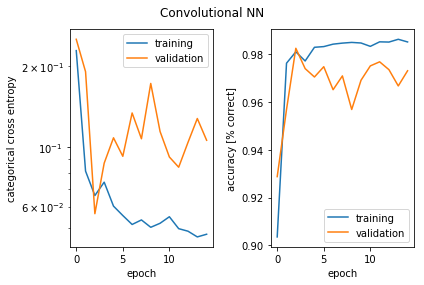

In [29]:
plot_history(cnnhistory, 'Convolutional NN')
print("Maximum accuracy: {}".format(np.max(cnnhistory.history['val_acc'])))

The model is trained considering a sliding window of dimensions 40*40 that slides all the image with a stride set to 10.
A non-max suppression is applied to remove all the overlapping boxeswith IoU of 0.1.
A big brawback of this method concerns the computational cost. We didn't try to merge different size of sliding window.

In [30]:
#this function is useful to create a sliding window through all the image with a stride of 3
def running_slide_window(image,stepSize,windowSize):
    nb_of_x_steps=np.floor((image.shape[1]-windowSize)/stepSize).astype('int')
    nb_of_y_steps=np.floor((image.shape[0]-windowSize)/stepSize).astype('int')
    for y in range( nb_of_y_steps):
        for x in range( nb_of_x_steps):
            yield ( stepSize*x,stepSize*y,image[stepSize*y:stepSize*y + windowSize, stepSize*x:stepSize*x + windowSize])

In [31]:
#this function implements the non max suppression algorithm: basically we sort all the predicted labels according 
#to their probability to detect a varroa and we remove the one with lowest probability that reach a 0.1 IoU overlap.

def nonmax_suppression( value, rectangle_values):
    
    
    rectangle_values=sorted(rectangle_values,key=operator.itemgetter(4),reverse=True)
    
    
    if len(rectangle_values)==1:
        return rectangle_values
    
    
    for i,values in enumerate(rectangle_values):
        rect_copy=rectangle_values[i+1:].copy()
        for second_value in rect_copy:
            if verify_intersection(values,second_value) :
                       iou=bb_intersection_over_union(values,second_value)
                       
                       if (iou >=0.1):
                         
                            rectangle_values.remove(second_value )
                            
    return rectangle_values
                         
 
                           
                             
        

In this section we made our predictions on a random image of the test set. As said before, this method is really computational
inefficient, just thinking that it takes about 10min to run this code on just one image (about 2000*2000 pixels)!
Before calling the algorithm of non-max suppression, another threshold is established of 0.99 to remove the predictions of lower probability

In [32]:
#look at the result:
import operator
rectangle_values={}
size_window=40

for i,images in enumerate(image_list[130:131]):# images as test set
    rectangle_values[str(i)]=[]
    #images=cv2.resize(images,dim,interpolation=cv2.INTER_LANCZOS4)
    
    for (x,y,window) in running_slide_window(images,10,size_window):#3 is the stride
        window=np.expand_dims(window,axis=0)
        pred=cnnmodel.predict_proba(window/255)
        
       
        #first thresholding
        if (pred[0][1]>0.999) :
         
            rectangle_values[str(i)].append([x,y,x+size_window,y+size_window,pred[0][1]])
            rectangle_values[str(i)]=nonmax_suppression(pred[0][1],rectangle_values[str(i)])

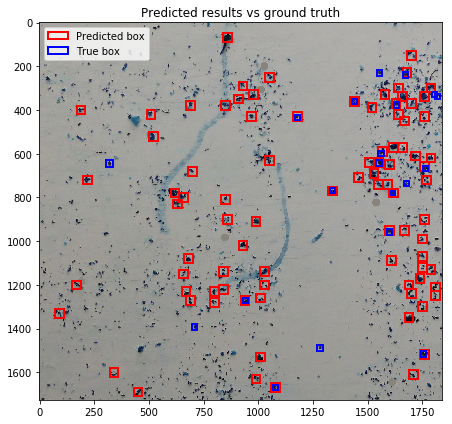

In [35]:
number=130 #first result


fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_list[number])

for values in rectangle_values[str(0)]:
        
        
        rect = mpatches.Rectangle((values[0], values[1]), size_window, size_window,
                                  fill=False, edgecolor='red', linewidth=2,label='Predicted box')
        ax.add_patch(rect)


        
for values in ground_truth[str(number)][0]:
    rect2=mpatches.Rectangle((values[0], values[1]),values[2]-values[0], values[3]-values[1],
                                  fill=False, edgecolor='blue', linewidth=2,label='True box')
       
    ax.add_patch(rect2)
plt.legend(handles=[rect,rect2])

plt.title('Predicted results vs ground truth')

plt.tight_layout()
plt.show()

In the second method the goal is to fast the computation, for this way we just deal with CNN, not considering the fully connected layer anymore. No size is imposed in the input shape of the CNN so we have the freedom to train any image of any size.

In [36]:
# 2 method = only cnn no fc for fast computation
cnnmodel = Sequential()
cnnmodel.add(Conv2D(32, kernel_size = (5,5), activation = 'relu',
            input_shape = (None,None,3)))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Conv2D(64, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Dropout(0.25))

cnnmodel.add(Conv2D(576, kernel_size = (3,3), activation = 'relu'))
cnnmodel.add(Dropout(0.25))
cnnmodel.add(Conv2D(100, kernel_size = (1,1), activation = 'relu'))
cnnmodel.add(Conv2D(2, kernel_size = (1,1), activation = 'sigmoid'))



In [37]:
adam = Adam()
cnnmodel.compile(loss = 'binary_crossentropy',
             optimizer = adam,
             metrics = ['accuracy'])
cnnhistory = cnnmodel.fit(train_set, np.expand_dims(np.expand_dims(train_label,axis=1),axis=2),
         epochs = 10,
         batch_size = 500,
         validation_split = .3)

Train on 10303 samples, validate on 4416 samples
Epoch 1/10
10303/10303 [==============================] - 21s 2ms/step - loss: 0.3403 - acc: 0.8407 - val_loss: 0.1991 - val_acc: 0.9261
Epoch 2/10
10303/10303 [==============================] - 17s 2ms/step - loss: 0.0942 - acc: 0.9733 - val_loss: 0.3207 - val_acc: 0.9415
Epoch 3/10
10303/10303 [==============================] - 17s 2ms/step - loss: 0.0771 - acc: 0.9794 - val_loss: 0.1785 - val_acc: 0.9614
Epoch 4/10
10303/10303 [==============================] - 17s 2ms/step - loss: 0.0605 - acc: 0.9835 - val_loss: 0.1064 - val_acc: 0.9715
Epoch 5/10
10303/10303 [==============================] - 17s 2ms/step - loss: 0.0526 - acc: 0.9844 - val_loss: 0.1370 - val_acc: 0.9657
Epoch 6/10
10303/10303 [==============================] - 18s 2ms/step - loss: 0.0480 - acc: 0.9843 - val_loss: 0.1370 - val_acc: 0.9639
Epoch 7/10
10303/10303 [==============================] - 19s 2ms/step - loss: 0.0487 - acc: 0.9839 - val_loss: 0.1582 - val_acc:

Maximum accuracy: 0.9731657580081103


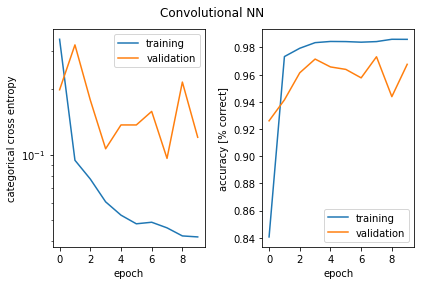

In [38]:
plot_history(cnnhistory, 'Convolutional NN')
print("Maximum accuracy: {}".format(np.max(cnnhistory.history['val_acc'])))

In [39]:
#this function helps to find the stride that it's applied to each image when is trained by our model:
def finding_stride(pred,size_window,images):
    
        
    return np.floor((images.shape[1]-size_window)/(pred.shape[0]-1))




After training the model, let's see how it is performing on the training set, 'image_list' contains all the 800 input images, but to make the computation more fast we just consider the first 50 !

In [40]:
cnn_rectangle_train_values={}
for k,images in enumerate(image_list[0:50]):
    cnn_rectangle_train_values[str(k)]=[]
    images=np.expand_dims(images,axis=0)
    pred=cnnmodel.predict_proba(images/255)
    pred=pred.squeeze()
    pred=pred[:,:,1]
    stride=finding_stride(pred,size_window,images)
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            if pred[i,j]>0.999: # first filter
                filter_size=[(j)*stride,(i)*stride,(j)*stride+size_window,(i)*stride+size_window,pred[i,j]]
                cnn_rectangle_train_values[str(k)].append(filter_size )
                cnn_rectangle_train_values[str(k)]=nonmax_suppression(pred[i,j],cnn_rectangle_train_values[str(k)])

now let's compare the results with the labels from the ground_truth dictionary and save into another dictionary (cnn_rectangle_train_fp_values) all the false positive for retrain our network!!!

In [41]:
threshold=0.3
tp,fp,fn=0,0,0
cnn_rectangle_train_fp_values={}


for i in range( len(list(ground_truth.keys())[0:50])):
    print('nb of image:{}'.format(i))
    df=pd.DataFrame(index=range(len(ground_truth[str(i)][0])), columns=range(len(cnn_rectangle_train_values[str(i)])))
    for  k,real_value in enumerate(ground_truth[str(i)][0]):

        for j,prediction in enumerate(cnn_rectangle_train_values[str(i)]):#for each prediction let's calculate the IoU respect to each target

                if verify_intersection(real_value,prediction) :
                       iou=bb_intersection_over_union(prediction,real_value)
                       df.loc[k,j]=iou
                else :

                    df.loc[k,j]=0
    #counting the number of true positive, false postive and false negative               
    
    
    fp+=np.sum(df.max(axis=0)<threshold)
    values_fp=df.loc[:,df.max(axis=0)<threshold].columns.values
    cnn_rectangle_train_fp_values[str(i)]=[]
    for p in values_fp:
    
        cnn_rectangle_train_fp_values[str(i)].append(cnn_rectangle_train_values[str(i)][p])
    
   

nb of image:0
nb of image:1
nb of image:2
nb of image:3
nb of image:4
nb of image:5
nb of image:6
nb of image:7
nb of image:8
nb of image:9
nb of image:10
nb of image:11
nb of image:12
nb of image:13
nb of image:14
nb of image:15
nb of image:16
nb of image:17
nb of image:18
nb of image:19
nb of image:20
nb of image:21
nb of image:22
nb of image:23
nb of image:24
nb of image:25
nb of image:26
nb of image:27
nb of image:28
nb of image:29
nb of image:30
nb of image:31
nb of image:32
nb of image:33
nb of image:34
nb of image:35
nb of image:36
nb of image:37
nb of image:38
nb of image:39
nb of image:40
nb of image:41
nb of image:42
nb of image:43
nb of image:44
nb of image:45
nb of image:46
nb of image:47
nb of image:48
nb of image:49


create a new training set made of the false positive detection and assign to them a zero label :



In [42]:
tot_labels_train_fp=[]
tot_images_train_fp=[]
labels=[]

#training data from po samples
for i,values in enumerate((cnn_rectangle_train_fp_values.values())):
    
        flatten =  [sublist for sublist in values ]
        
        image_varroa=[resize_image(image_list[i][int(pixels[1]):int(pixels[3]),int(pixels[0]):int(pixels[2]),:])   for (pixels) in (flatten)]
        labels=[0 for j in range(len(image_varroa))]
    
        
        tot_images_train_fp,tot_labels_train_fp=concatenate(image_varroa,labels,tot_labels_train_fp,tot_images_train_fp)


nb_of_fp_sample=len(tot_labels_train_fp)

let's still consider the principle of class-balance and take the same amount of positive classes:

In [43]:
for i,values in enumerate((list(varroa_images.values())[0:100])):
    
        flatten =  [item for sublist in values for item in (sublist) ]
        image_nb=int(list(varroa_images.keys())[i])
        image_varroa=[resize_image(image_list[image_nb][pixels[1]:pixels[3],pixels[0]:pixels[2],:])   for pixels in (flatten)]
        labels=[1 for j in range(len(image_varroa))]
    
        
        tot_images_train_fp,tot_labels_train_fp=concatenate(image_varroa,labels,tot_labels_train_fp,tot_images_train_fp)




In [44]:
#normalization of the training data
train_set=np.asarray(tot_images_train_fp)/255
train_label=keras.utils.to_categorical(tot_labels_train_fp) 

In [2]:
adam = Adam()
cnnmodel.compile(loss = 'binary_crossentropy',
             optimizer = adam,
             metrics = ['accuracy'])
cnnhistory = cnnmodel.fit(train_set, np.expand_dims(np.expand_dims(train_label,axis=1),axis=2),
         epochs = 20,
         batch_size = 100,
         validation_split = .3,shuffle=True, verbose=0)

In [4]:
# Save the weights
cnnmodel.save_weights('./model/best.h5')

In [6]:
# Load the weights
cnnmodel.laod_weights('./model/best.h5')

testing the final netwrok on the 50 test images:

In [51]:
cnn_rectangle_values={}
for k,images in enumerate(image_test_list):
    cnn_rectangle_values[str(k)]=[]
    images=np.expand_dims(images,axis=0)
    pred=cnnmodel.predict_proba(images/255)
    pred=pred.squeeze()
    pred=pred[:,:,1]
    stride=finding_stride(pred,size_window,images)
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            if pred[i,j]>0.99: # first filter
                filter_size=[(j)*stride,(i)*stride,(j)*stride+size_window,(i)*stride+size_window,pred[i,j]]
                cnn_rectangle_values[str(k)].append(filter_size )
                cnn_rectangle_values[str(k)]=nonmax_suppression(pred[i,j],cnn_rectangle_values[str(k)])


In [52]:
threshold=0.3
tp,fp,fn=0,0,0

#run for the test_images
for i in range( len(ground_test_truth.keys())):
    print('nb of image:{}'.format(i))
    df=pd.DataFrame(index=range(len(ground_test_truth[str(i)][0])), columns=range(len(cnn_rectangle_values[str(i)])))
    for  k,real_value in enumerate(ground_test_truth[str(i)][0]):

        for j,prediction in enumerate(cnn_rectangle_values[str(i)]):#for each prediction let's calculate the IoU respect to each target

                if verify_intersection(real_value,prediction) :
                       iou=bb_intersection_over_union(prediction,real_value)
                        df.loc[k,j]=iou
                else :

                    df.loc[k,j]=0
     #counting the number of true positive, false postive nd false negative               
    tp+=np.sum(df.max(axis=1)>=threshold)
    fp+=np.sum(df.max(axis=0)<threshold)
    fn+=np.sum(df.max(axis=1)<threshold)

nb of image:0
nb of image:1
nb of image:2
nb of image:3
nb of image:4
nb of image:5
nb of image:6
nb of image:7
nb of image:8
nb of image:9
nb of image:10
nb of image:11
nb of image:12
nb of image:13
nb of image:14
nb of image:15
nb of image:16
nb of image:17
nb of image:18
nb of image:19
nb of image:20
nb of image:21
nb of image:22
nb of image:23
nb of image:24
nb of image:25
nb of image:26
nb of image:27
nb of image:28
nb of image:29
nb of image:30
nb of image:31
nb of image:32
nb of image:33
nb of image:34
nb of image:35
nb of image:36
nb of image:37
nb of image:38
nb of image:39
nb of image:40
nb of image:41
nb of image:42
nb of image:43
nb of image:44
nb of image:45
nb of image:46
nb of image:47
nb of image:48
nb of image:49


In [54]:
print('precision',tp/(tp+fp))
print('recall',tp/(tp+fn))
print('F1',( 2*tp/(tp+fn) * tp/(tp+fp) )/(tp/(tp+fp)+tp/(tp+fn)))

precision 0.7857142857142857
recall 0.39461883408071746
F1 0.5253731343283582


Show the false positive to re-train

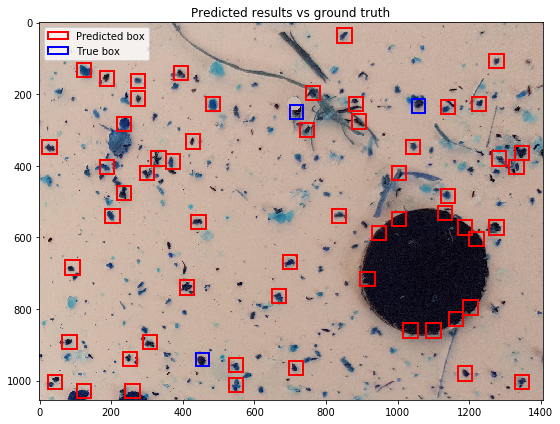

In [587]:
number=49

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_list[number])

for values in cnn_rectangle_train_fp_values[str(number)]:
        
        
        rect = mpatches.Rectangle((values[0], values[1]), size_window, size_window,
                                  fill=False, edgecolor='red', linewidth=2,label='Predicted box')
        ax.add_patch(rect)


        
for values in ground_truth[str(number)][0]:
    rect2=mpatches.Rectangle((values[0], values[1]),values[2]-values[0], values[3]-values[1],
                                  fill=False, edgecolor='blue', linewidth=2,label='True box')
       
    ax.add_patch(rect2)
plt.legend(handles=[rect,rect2])

plt.title('Predicted results vs ground truth')

plt.tight_layout()
plt.show()

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [ ]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [38]:
#Your code